# LDA para legislações de turismo em Minas Gerais (MG) de 1990 a 1999:
93 legislações de 2010 até 2019.

Os documentos estão armazenados em um Drive particular dos pesquisadores.

## Importação das bibliotecas:

In [1]:
# Para ler o PDF:
import PyPDF2
from PyPDF2 import PdfMerger

# Para analisar o layout do PDF e extrair o texto:
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure

# Para extrair textos de tabelas em PDF:
import pdfplumber

# Para extrair as imagens dos PDFs:
from PIL import Image
from pdf2image import convert_from_path

# Para fazer Reconhecimento Ótico de Caracteres (OCR) para extrair textos das imagens:
import pytesseract

# Para remover os arquivos adicionais criados:
import os

# Para manipulação e análise dos dados:
import pandas as pd
import numpy as np
from collections import Counter
import pickle

# Para acompanhar a execução dos códigos:
from tqdm import tqdm

# Para análise dos dados textuais:
import re
import nltk
import spacy
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

# Para visualizações:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
from nltk import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Download do modelo para língua portuguesa:
spacy.cli.download("pt_core_news_lg")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


In [3]:
# Carregamento do modelo:
nlp = spacy.load('pt_core_news_lg')

### Todos os arquivos serão reunidos em um único PDF. Após isso será aplicado a extração do texto, o pré-processamento e a técnica LDA.

In [4]:
# Caminho da pasta onde estão os arquivos:
pasta_pdf = r"C:\Users\hugob\OneDrive\Desktop\legislacao_MG\Legislacoes MG_2010_a_2019"

In [5]:
# Lista todos os arquivos PDF na pasta
arquivos_pdf = [f for f in os.listdir(pasta_pdf) if f.endswith('.pdf')]

In [6]:
# Cria um objeto PdfMerger
mesclador = PdfMerger()

# Adiciona cada arquivo PDF ao PdfMerger
for arquivo in tqdm(arquivos_pdf, desc="Mesclando PDFs"):
    caminho_pdf = os.path.join(pasta_pdf, arquivo)
    mesclador.append(caminho_pdf)

# Salva o PDF mesclado em um novo arquivo
arquivo_saida = r"C:\Users\hugob\Dropbox\Hugo_Bovareto\Artigo_Legislacao_Turismo\Legislacoes MG_2010_a_2019\Legislacao_2010_a_2019_MG.pdf"
mesclador.write(arquivo_saida)
mesclador.close()

Mesclando PDFs: 100%|██████████████████████████████████████████████████████████████████| 97/97 [00:07<00:00, 13.70it/s]


## 2. Extração das informações do PDF:

In [7]:
# Caminho do arquivo em PDF:
pdf_path = r"C:\Users\hugob\Dropbox\Hugo_Bovareto\Artigo_Legislacao_Turismo\Legislacoes MG_2010_a_2019\Legislacao_2010_a_2019_MG.pdf"

In [8]:
def extrair_texto_pdf(nome_arquivo):
    with open(nome_arquivo, 'rb') as file:
        leitor_pdf = PyPDF2.PdfReader(file)
        num_paginas = len(leitor_pdf.pages)
        texto_por_pagina = []

        for pagina_num in tqdm(range(num_paginas), desc="Extraindo texto"):
            pagina = leitor_pdf.pages[pagina_num]
            texto = pagina.extract_text()
            texto_por_pagina.append(texto)

    return texto_por_pagina

def criar_dataframe(texto_por_pagina):
    df = pd.DataFrame({"Página": range(1, len(texto_por_pagina) + 1), "Texto": texto_por_pagina})
    return df

if __name__ == "__main__":
    pdf_path = pdf_path
    texto_por_pagina = extrair_texto_pdf(pdf_path)
    df = criar_dataframe(texto_por_pagina)
    
# Exibir o DataFrame:
df

Extraindo texto: 100%|█████████████████████████████████████████████████████████████| 4727/4727 [03:16<00:00, 24.07it/s]


,Página,Texto
0,1,"06/10/2023, 13:00 Portal da Assembleia Legisla..."
1,2,"06/10/2023, 13:00 Portal da Assembleia Legisla..."
2,3,"06/10/2023, 13:00 Portal da Assembleia Legisla..."
3,4,"06/10/2023, 13:00 Portal da Assembleia Legisla..."
4,5,"06/10/2023, 13:00 Portal da Assembleia Legisla..."
...,...,...
4722,4723,"05/10/2023, 15:54 Portal da Assembleia Legisla..."
4723,4724,"05/10/2023, 15:54 Portal da Assembleia Legisla..."
4724,4725,"05/10/2023, 15:54 Portal da Assembleia Legisla..."
4725,4726,"05/10/2023, 15:54 Portal da Assembleia Legisla..."


In [9]:
# Nome do arquivo original (sem extensão)
original_filename1 = os.path.splitext(os.path.basename(pdf_path))[0]

# Nome do arquivo pkl a ser salvo
pkl_filename1 = f"paginas_completas_{original_filename1}.pkl"

In [10]:
# Salvar o DataFrame:
df.to_pickle(pkl_filename1)

## 3. Pré-processamento dos dados:

In [4]:
df = pd.read_pickle(r"C:\Users\hugob\Dropbox\Hugo_Bovareto\Artigo_Legislacao_Turismo\paginas_completas_510_legislacoes_turismo_MG.pkl")

### Remoção de cabeçalho sem valor para as legislações:

In [11]:
# Função para remover links que começam com "https:"
def remove_links(texto):
    # Expressão regular que remove links, considerando espaços antes dos pontos
    return re.sub(r'https:\/\/(\S*\s*\.\s*)+\S*', '', texto)

# Aplicar a função a toda a coluna "Texto"
df['Texto'] = df['Texto'].apply(remove_links)

In [12]:
# Sequências específicas de palavras que você deseja remover
sequencia = "Portal da Assembleia Legislativa de Minas Gerais"

In [13]:
# Função para substituir a primeira ocorrência da sequência por uma string vazia
df['Texto'] = df['Texto'].apply(lambda x: x.replace(sequencia, "", 1))

In [14]:
#Exclusão de sinalização de parágrafos (\n):
df['Texto'] = df['Texto'].apply(lambda x: x.replace("\n", " "))

In [15]:
# Função para adicionar espaços entre palavras unidas
def separar_palavras(texto):
    # Expressão regular para encontrar minúscula seguida por maiúscula e inserir um espaço entre elas
    return re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', texto)

# Aplicar a função a toda a coluna "Texto"
df['Texto'] = df['Texto'].apply(separar_palavras)

In [16]:
df

,Página,Texto
0,1,"06/10/2023, 13:00 1/28  LEI nº 19.099, de ..."
1,2,"06/10/2023, 13:00 2/28Art. 2º As prioridades..."
2,3,"06/10/2023, 13:00 3/28I - o incentivo financ..."
3,4,"06/10/2023, 13:00 4/28Art. 8º Acompanharão a..."
4,5,"06/10/2023, 13:00 5/28Serviços de Transporte..."
...,...,...
4722,4723,"05/10/2023, 15:54 114/116Unidade Orçamentári..."
4723,4724,"05/10/2023, 15:54 115/116Território Físicas ..."
4724,4725,"05/10/2023, 15:54 116/116Sudoeste 67.320 961..."
4725,4726,"05/10/2023, 15:54 1/1  Lei nº 23.253, de 0..."


### Separação e tokenização das frases:

As análises serão feitas separando os textos por frases.

In [18]:
from nltk.tokenize import sent_tokenize

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hugob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
# Função para separar as frases de cada página:
def separar_frases(texto):
    return sent_tokenize(texto, language='portuguese')

In [21]:
# Método apply para aplicar a função em cada linha:
df['frases'] = df['Texto'].astype(str).apply(separar_frases)

In [22]:
# Expandir cada frase em uma linha e criar um novo dataframe:
df = pd.DataFrame(df['frases'].explode().reset_index(drop=True))

### Remoção de acentos, palavras com menos de 3 ou mais de 50 caracteres:

In [23]:
# Converter todos os valores da coluna 'frases' para string para evitar erros com a função simple_preprocess da biblioteca Gensim:
df['frases'] = df['frases'].astype(str)

In [24]:
# Função para pré-processar o texto usando a função simple_preprocess da biblioteca Gensim
# (remove acentos, ignora palavras com enos de 3 caracteres ou mais de 50):
def preprocessar_texto(texto):
    preprocessado = simple_preprocess(texto, deacc=True, min_len=3, max_len=50)
    return preprocessado

In [25]:
# Aplicar a função de pré-processamento para criar a nova coluna:
df['Preprocessado'] = df['frases'].apply(preprocessar_texto)

In [26]:
# Remover as linhas com somente o texto "art", referente a artigo:
df = df[df['Preprocessado'].apply(lambda x: x != ["art"])]

### Remover Stop words:

In [27]:
# Stop words da biblioteca Spacy:
stopwords_spacy = spacy.lang.pt.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(stopwords_spacy))

Number of stop words: 416


In [28]:
# Função para remover as stop words:
def remover_stopwords_spacy(texto):
    return [palavra for palavra in texto if palavra not in stopwords_spacy]

In [29]:
df['Sem_stopwords'] = df['Preprocessado'].apply(remover_stopwords_spacy)

In [30]:
df

,frases,Preprocessado,Sem_stopwords
0,"06/10/2023, 13:00 1/28  LEI nº 19.099, de ...","[lei, texto, atualizado, dispoe, sobre, diretr...","[lei, texto, atualizado, dispoe, diretrizes, e..."
1,"O GOVERNADOR DO ESTADO DE MINAS GERAIS, O Povo...","[governador, estado, minas, gerais, povo, esta...","[governador, minas, gerais, minas, gerais, rep..."
2,"1º Ficam estabelecidas, em cumprimento ao disp...","[ficam, estabelecidas, cumprimento, disposto, ...","[ficam, estabelecidas, cumprimento, disposto, ..."
3,155 da Constituição do Estado e na Lei Complem...,"[constituicao, estado, lei, complementar, fede...","[constituicao, lei, complementar, federal, mai..."
4,CAPÍTULO II DAS PRIORIDADES E METAS DA ADMINIS...,"[capitulo, das, prioridades, metas, administra...","[capitulo, prioridades, metas, administracao, ..."
...,...,...,...
21959,1º – Ficam reconhecidos o relevante interesse ...,"[ficam, reconhecidos, relevante, interesse, co...","[ficam, reconhecidos, relevante, interesse, co..."
21960,Parágrafo único – A declaração de utilidade pú...,"[paragrafo, unico, declaracao, utilidade, publ...","[paragrafo, unico, declaracao, utilidade, publ..."
21962,2º – Esta lei entra em vigor na data de sua pu...,"[esta, lei, entra, vigor, data, sua, publicacao]","[lei, entra, vigor, data, publicacao]"
21963,"Belo Horizonte, aos 4 de janeiro de 2019; 231º...","[belo, horizonte, aos, janeiro, inconfidencia,...","[belo, horizonte, janeiro, inconfidencia, mine..."


### Stemização:

Há várias opções de stemmers na biblioteca NLTK. Utilizaremos o RSLP que é específico para língua portuguesa.
(https://www.nltk.org/_modules/nltk/stem/rslp.html; https://dfalbel.github.io/rslp/)

In [31]:
from nltk.stem import RSLPStemmer

In [32]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\hugob\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [33]:
def stem_RSLPS(tokens):
    stemmer = RSLPStemmer()
    stem_tokens = [stemmer.stem(token) for token in tokens]
    return stem_tokens

In [34]:
df['Stem'] = df['Sem_stopwords'].apply(stem_RSLPS)

In [35]:
df

,frases,Preprocessado,Sem_stopwords,Stem
0,"06/10/2023, 13:00 1/28  LEI nº 19.099, de ...","[lei, texto, atualizado, dispoe, sobre, diretr...","[lei, texto, atualizado, dispoe, diretrizes, e...","[lei, text, atual, dispo, diretriz, elaboraca,..."
1,"O GOVERNADOR DO ESTADO DE MINAS GERAIS, O Povo...","[governador, estado, minas, gerais, povo, esta...","[governador, minas, gerais, minas, gerais, rep...","[govern, min, geral, min, geral, represent, de..."
2,"1º Ficam estabelecidas, em cumprimento ao disp...","[ficam, estabelecidas, cumprimento, disposto, ...","[ficam, estabelecidas, cumprimento, disposto, ...","[fic, estabelec, cumpr, dispost, art]"
3,155 da Constituição do Estado e na Lei Complem...,"[constituicao, estado, lei, complementar, fede...","[constituicao, lei, complementar, federal, mai...","[constituica, lei, complement, feder, mai, dir..."
4,CAPÍTULO II DAS PRIORIDADES E METAS DA ADMINIS...,"[capitulo, das, prioridades, metas, administra...","[capitulo, prioridades, metas, administracao, ...","[capitul, prior, met, administraca, publ, estad]"
...,...,...,...,...
21959,1º – Ficam reconhecidos o relevante interesse ...,"[ficam, reconhecidos, relevante, interesse, co...","[ficam, reconhecidos, relevante, interesse, co...","[fic, reconhec, relev, inter, cole, importanc,..."
21960,Parágrafo único – A declaração de utilidade pú...,"[paragrafo, unico, declaracao, utilidade, publ...","[paragrafo, unico, declaracao, utilidade, publ...","[paragraf, unic, declaraca, util, publ, circui..."
21962,2º – Esta lei entra em vigor na data de sua pu...,"[esta, lei, entra, vigor, data, sua, publicacao]","[lei, entra, vigor, data, publicacao]","[lei, entr, vig, dat, publicaca]"
21963,"Belo Horizonte, aos 4 de janeiro de 2019; 231º...","[belo, horizonte, aos, janeiro, inconfidencia,...","[belo, horizonte, janeiro, inconfidencia, mine...","[bel, horizont, jan, inconfidenc, min, indepen..."


In [46]:
# Nome do arquivo original (sem extensão)
original_filename2 = os.path.splitext(os.path.basename(pdf_path))[0]

# Nome do arquivo pkl a ser salvo
pkl_filename2 = f"stem_{original_filename2}.pkl"

In [47]:
# Salvar o DataFrame como arquivo .pkl
df.to_pickle(pkl_filename2)

## 4. LDA:

In [52]:
# Criar o dicionário de palavras
dicionario = corpora.Dictionary(df['Stem'])

In [53]:
# Criar o corpus
corpus = [dicionario.doc2bow(text) for text in df['Stem']]

### Identificação do melhor valor para Coherence Score:

In [40]:
# Função para testar vários coherence scores e perplexities:

def compute_performance(dictionary, corpus, texts, limit, start, step):
    """
    Computa c_v coherence score para vários números de tópicos.

    Parâmetros:
    dicionário: dicionario;
    corpus: corpus;
    texts: lista de listas com as palavras pré-processadas do documento;
    limit: Máximo nº de tópicos;
    start: Nº de tópicos inicial;
    step: intervalo entre os nº de tópicos testados.

    Resultados:
    model_list: lista de modelos LDA.
    coherence_values: valores de coerência correspondentes ao modelo LDA com o respectivo nº de tópicos.
    """
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus,
                         num_topics=num_topics,
                         id2word=dicionario,
                         random_state=42,
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)

    return model_list, coherence_values, perplexity_values

In [41]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=1,
                                                                           limit=102,
                                                                           step=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [15:33<00:00, 44.46s/it]


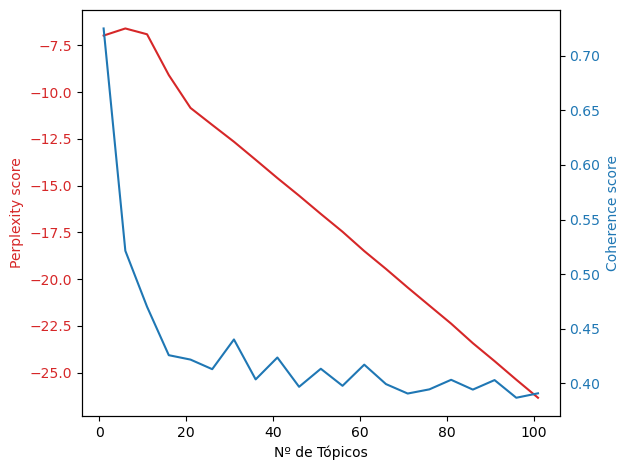

In [42]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=102; start=1; step=5;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('Legislacao_2010_a_2019_MG_Coherence Score_100 topicos.png')

plt.show()

In [43]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 1  tem um valor de coerência de  0.7252  e valor de perplexidade de -6.9782
A quantidade de tópicos = 6  tem um valor de coerência de  0.5213  e valor de perplexidade de -6.599
A quantidade de tópicos = 11  tem um valor de coerência de  0.47  e valor de perplexidade de -6.9097
A quantidade de tópicos = 16  tem um valor de coerência de  0.4256  e valor de perplexidade de -9.0885
A quantidade de tópicos = 21  tem um valor de coerência de  0.4215  e valor de perplexidade de -10.8455
A quantidade de tópicos = 26  tem um valor de coerência de  0.4128  e valor de perplexidade de -11.7539
A quantidade de tópicos = 31  tem um valor de coerência de  0.44  e valor de perplexidade de -12.6526
A quantidade de tópicos = 36  tem um valor de coerência de  0.4034  e valor de perplexidade de -13.6174
A quantidade de tópicos = 41  tem um valor de coerência de  0.4234  e valor de perplexidade de -14.5936
A quantidade de tópicos = 46  tem um valor de coerência de  0.3966  e valor

In [54]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=1,
                                                                           limit=35,
                                                                           step=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [23:00<00:00, 40.61s/it]


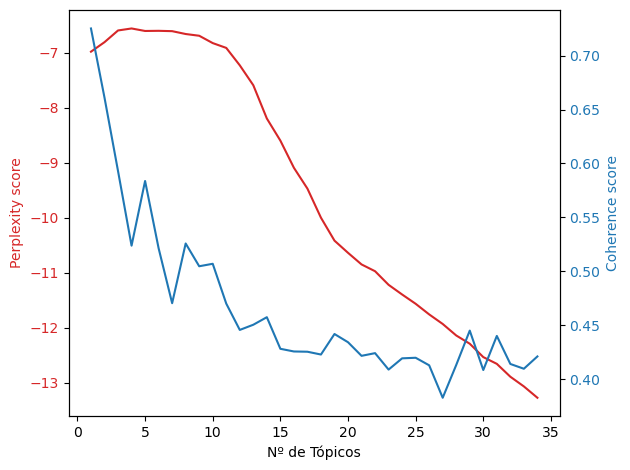

In [55]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=35; start=1; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('Legislacao_2010_a_2019_MG_Coherence Score_35 topicos.png')

plt.show()

In [56]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 1  tem um valor de coerência de  0.7252  e valor de perplexidade de -6.9782
A quantidade de tópicos = 2  tem um valor de coerência de  0.661  e valor de perplexidade de -6.8054
A quantidade de tópicos = 3  tem um valor de coerência de  0.5929  e valor de perplexidade de -6.5927
A quantidade de tópicos = 4  tem um valor de coerência de  0.5237  e valor de perplexidade de -6.5562
A quantidade de tópicos = 5  tem um valor de coerência de  0.5837  e valor de perplexidade de -6.6019
A quantidade de tópicos = 6  tem um valor de coerência de  0.5213  e valor de perplexidade de -6.599
A quantidade de tópicos = 7  tem um valor de coerência de  0.4704  e valor de perplexidade de -6.6052
A quantidade de tópicos = 8  tem um valor de coerência de  0.5257  e valor de perplexidade de -6.6572
A quantidade de tópicos = 9  tem um valor de coerência de  0.5046  e valor de perplexidade de -6.6886
A quantidade de tópicos = 10  tem um valor de coerência de  0.5069  e valor de perpl

In [68]:
# Valor escolhido para coherence score foi 9 tópicos (coherence score = 0.5837).
# Número de tópicos
num_topicos = 5

In [69]:
# Inputar os dados e rodar o modelo LDA:
modelo_lda = LdaModel(corpus=corpus,
                      id2word=dicionario,
                      num_topics=num_topicos,
                      random_state=42,
                      per_word_topics=True)

In [70]:
# Imprimir os tópicos:
for topic_id in range(num_topicos):
    print(f"Topic {topic_id}: {modelo_lda.show_topic(topic_id)}")

Topic 0: [('atenca', 0.055494003), ('cult', 0.02548197), ('fortalec', 0.02088445), ('saud', 0.020230742), ('estad', 0.017712995), ('aquisica', 0.016419668), ('poli', 0.014674685), ('financ', 0.0109749595), ('desenvolv', 0.010133424), ('publ', 0.009760431)]
Topic 1: [('desp', 0.05571029), ('saud', 0.043568738), ('fund', 0.04010002), ('orcament', 0.03990513), ('corr', 0.037599634), ('unidad', 0.037289646), ('objet', 0.036911294), ('emend', 0.03558095), ('deduca', 0.035182152), ('incis', 0.034994435)]
Topic 2: [('art', 0.028349806), ('publ', 0.025746161), ('escol', 0.025116513), ('incis', 0.017086403), ('serv', 0.009779265), ('poli', 0.009406393), ('caput', 0.007920728), ('estad', 0.007056791), ('orga', 0.0070285085), ('nao', 0.0067598643)]
Topic 3: [('lei', 0.048640173), ('prim', 0.039087113), ('dad', 0.022268686), ('art', 0.022121865), ('comissa', 0.017936045), ('ate', 0.017342072), ('anex', 0.01384978), ('seguint', 0.013334838), ('fgd', 0.0101426635), ('carg', 0.010037746)]
Topic 4: [(

### Visualizações:

In [71]:
# Visualização dos tópicos:
visualizacao_legis_MG = pyLDAvis.gensim_models.prepare(modelo_lda, corpus, dicionario, n_jobs=1)

In [72]:
# Salvar a visualização como um arquivo HTML:
pyLDAvis.save_html(visualizacao_legis_MG, r"Legislacao_2010_a_2019_5_topicos.html")

### Distribuição de palavras por frase:

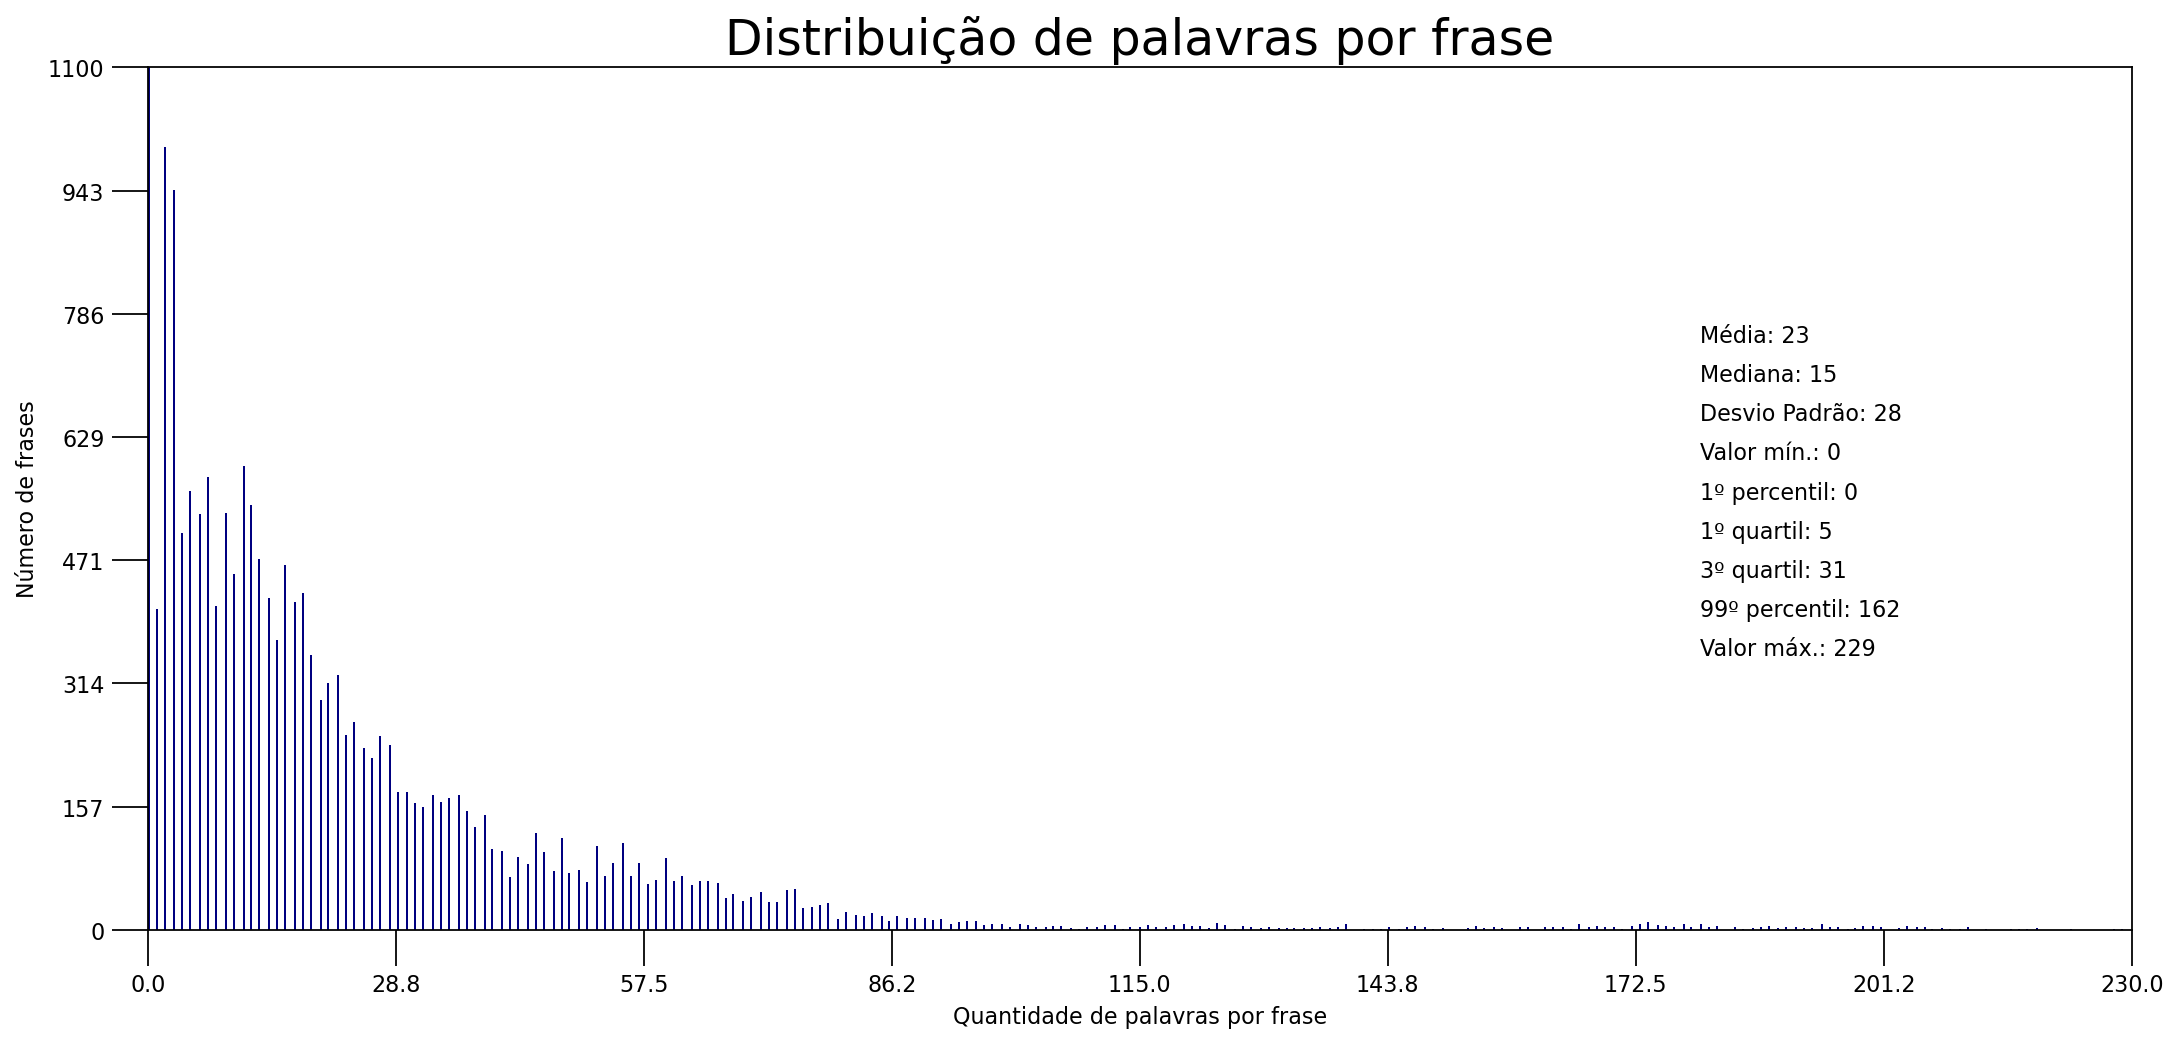

In [77]:
doc_lens = [len(d) for d in df['Stem']]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(180, 750, "Média: " + str(round(np.mean(doc_lens))))
plt.text(180, 700, "Mediana: " + str(round(np.median(doc_lens))))
plt.text(180, 650, "Desvio Padrão: " + str(round(np.std(doc_lens))))
plt.text(180, 600, "Valor mín.: " + str(round(np.min(doc_lens))))
plt.text(180, 550, "1º percentil: " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(180, 500, "1º quartil: " + str(round(np.quantile(doc_lens, q=0.25))))
plt.text(180, 450, "3º quartil: " + str(round(np.quantile(doc_lens, q=0.75))))
plt.text(180, 400, "99º percentil: " + str(round(np.quantile(doc_lens, q=0.99))))
plt.text(180, 350, "Valor máx.: " + str(round(np.max(doc_lens))))

plt.gca().set(xlim=(0, 230), ylim=(0, 1100), ylabel='Número de frases', xlabel='Quantidade de palavras por frase')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,230,9))
plt.yticks(np.linspace(0,1100,8))
plt.title('Distribuição de palavras por frase', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('Legislacao_2010_a_2019_Distribuicao_de_palavras_por_frase.png')

plt.show()

### Frequência de palavras em todo o documento:

In [78]:
# Concatenar todas as strings em uma única lista de palavras:
palavras = [palavra for lista in df['Stem'].values for palavra in lista]

# Calcular a frequência das palavras:
freq_dist = FreqDist(palavras)

# Obter as palavras mais frequentes:
top30_palavras = freq_dist.most_common(30)

# Criar um DataFrame com as palavras e suas frequências:
top30_palavras_df = pd.DataFrame(top30_palavras, columns=['Palavra', 'Frequência'])

# Imprimir o DataFrame:
top30_palavras_df

,Palavra,Frequência
0,incis,6563
1,desp,5674
2,unidad,5613
3,financ,5571
4,orcament,5366
5,lei,5333
6,emend,5156
7,benefici,4778
8,desenvolv,4701
9,fisic,4072


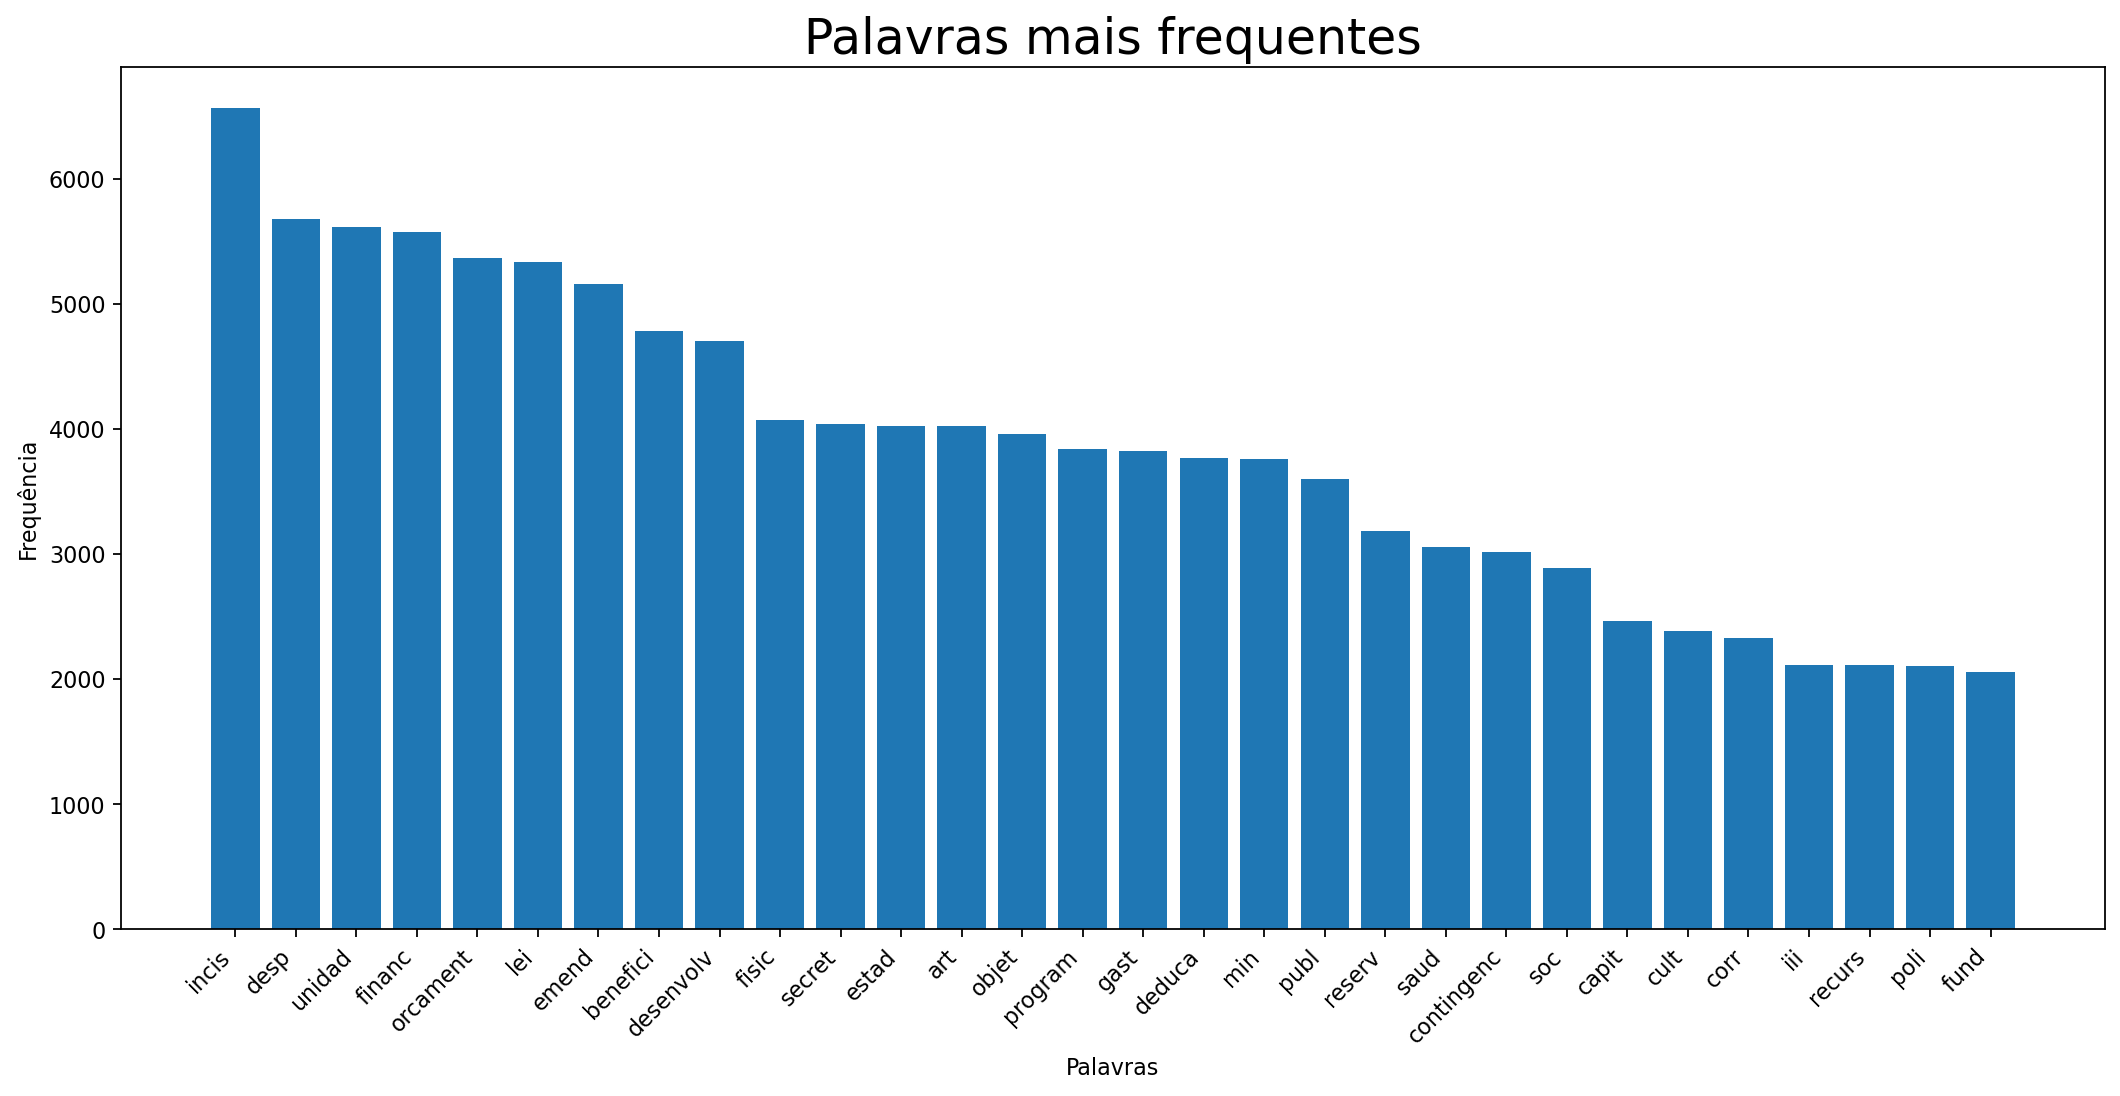

In [79]:
# Criar um gráfico de barras com as palavras mais frequentes:
plt.figure(figsize=(16,7), dpi=160)
plt.bar(top30_palavras_df['Palavra'], top30_palavras_df['Frequência'])
plt.title('Palavras mais frequentes', fontdict=dict(size=22))
plt.xlabel('Palavras')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequência')

# Salvar imagem:
plt.savefig('Legislacao_2010_a_2019_Palavras mais frequentes.png')

plt.show()

### Nuvem de palavras para todo o documento:

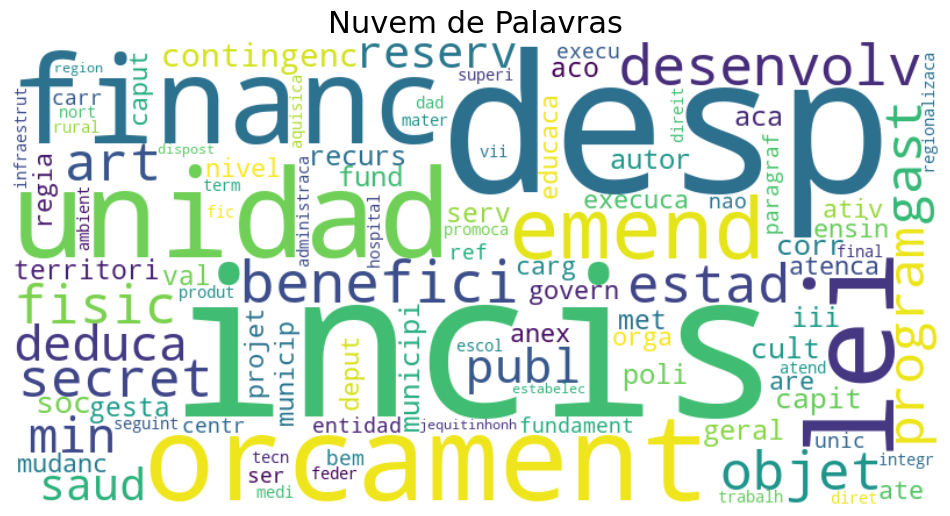

In [82]:
# Criar uma nuvem de palavras:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('Legislacao_2010_a_2019_Nuvem de palavras_corpus.png')

plt.show()

### Frequência de palavras em cada tópico:

In [83]:
# Criar DataFrame com frequência das palavras no corpus e relevância no tópico:
topics = modelo_lda.show_topics(formatted=False)
data_flat = [w for w_list in df['Stem'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_topicos = pd.DataFrame(out, columns=['Stem', 'topic_id', 'relevancia', 'frequencia'])

C:\Users\hugob\AppData\Local\Temp\ipykernel_23204\1529680503.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_23204\1529680503.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_23204\1529680503.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_23204\1529680503.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontal

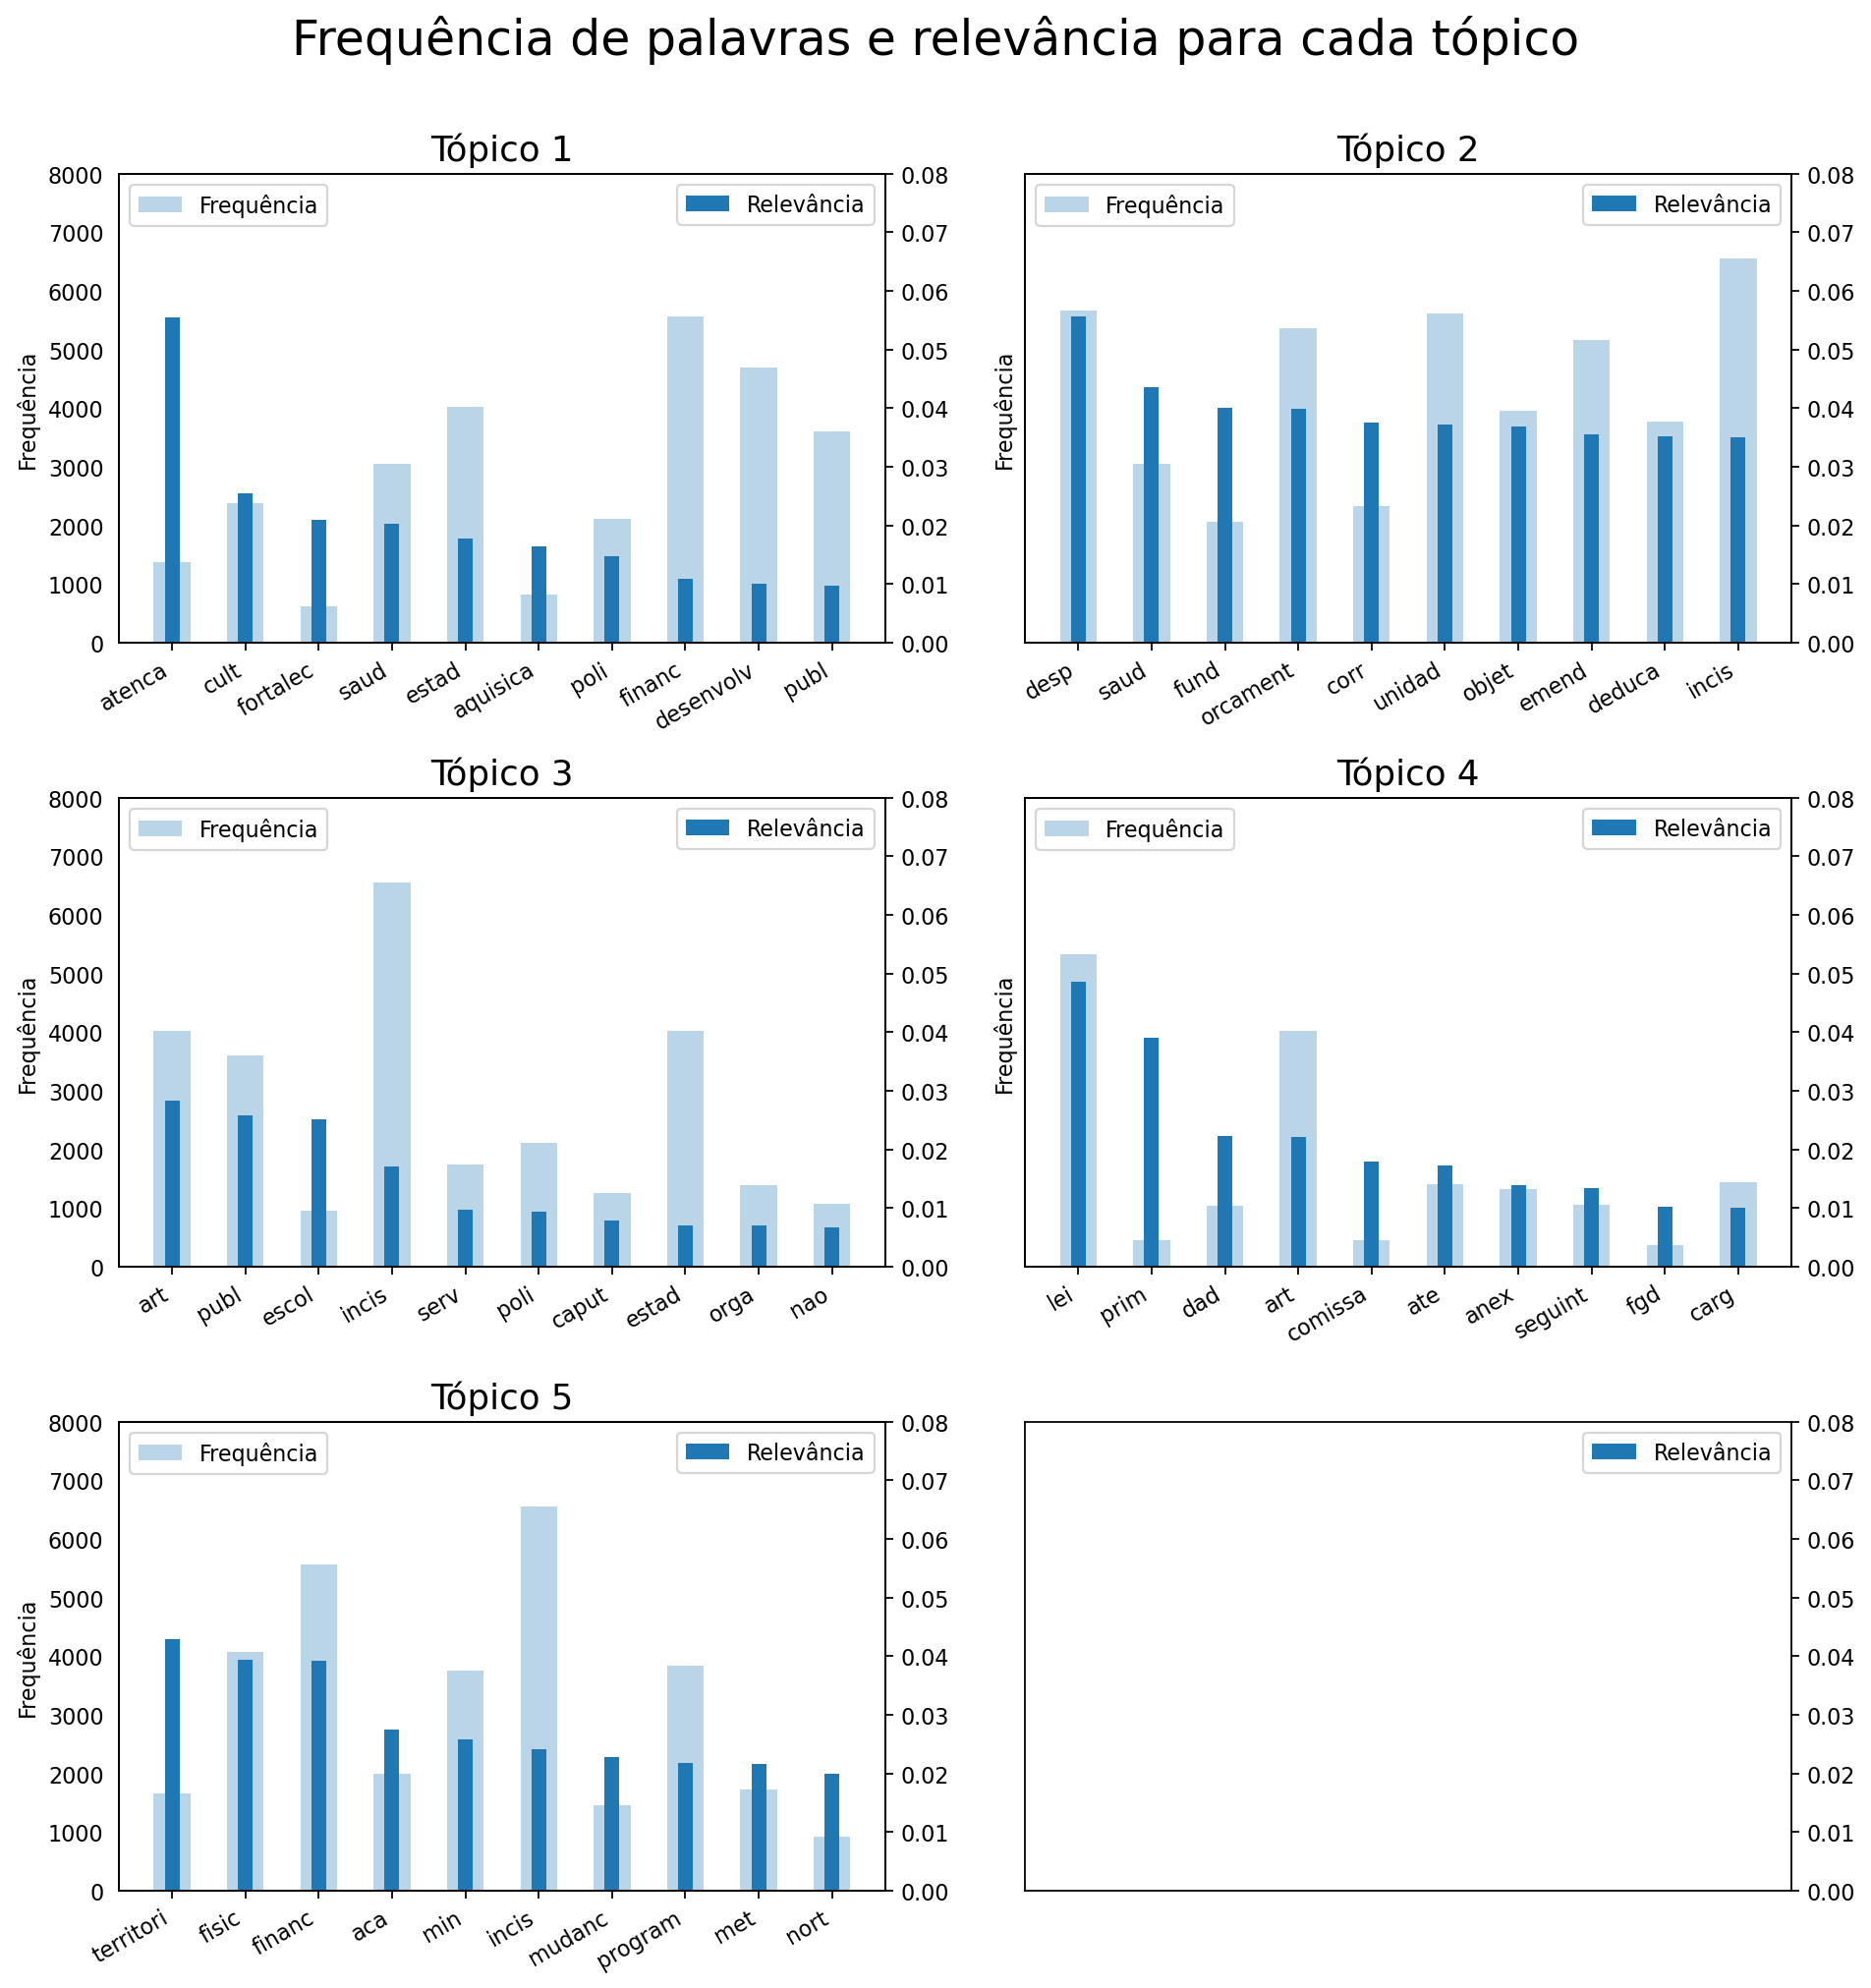

In [88]:
# Plotar contagem de palavras e pesos das palavras mais relevantes:
fig, axes = plt.subplots(3, 2, figsize=(12,12), sharey=True, dpi=160)

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='Stem', height="frequencia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.5, alpha=0.3, label='Frequência')
    ax_twin = ax.twinx()
    ax_twin.bar(x='Stem', height="relevancia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.2, label='Relevância')
    ax.set_ylabel('Frequência')
    ax_twin.set_ylim(0, 0.080); ax.set_ylim(0, 8000)
    ax.set_title('Tópico ' + str(i+1), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

# Excluir o 6º subplot (na 3ª linha e 2ª coluna):
fig.delaxes(axes[2, 1])
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Frequência de palavras e relevância para cada tópico', fontsize=22, y=1.05)

# Salvar imagem:
plt.savefig('Legislacao_2010_a_2019_Frequencia e relevancia de palavras por topico.png')

plt.show()

### Nuvem de palavras para cada tópico:

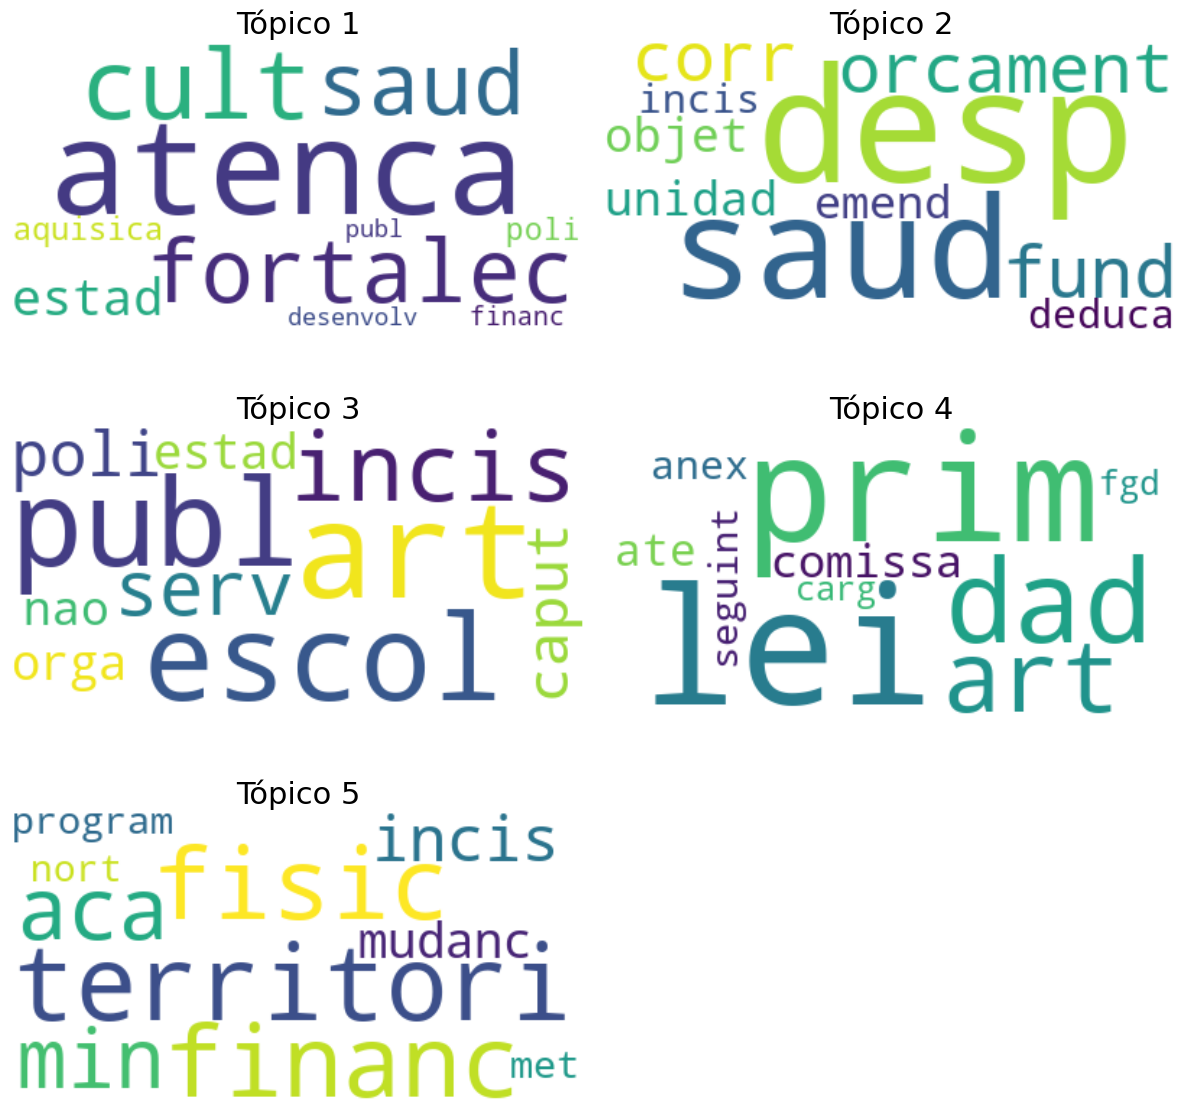

In [89]:
# Configuração do layout dos subplots
num_linhas = 3
num_colunas = 2

# Calcula o número total de subplots necessários
num_subplots = min(num_topicos, num_linhas * num_colunas)

fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(12, 12)) 

for topico_id in range(num_subplots):
    # Obter as palavras e frequências associados ao tópico:
    topico_palavras_pesos = modelo_lda.show_topic(topico_id)
    
    # Criar um dicionário de contagem de palavras e pesos:
    contagem_palavras = {palavra: peso for palavra, peso in topico_palavras_pesos}
    
    # Criar o objeto WordCloud:
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(contagem_palavras)
    
    # Adicionar subplot ao layout
    linha = topico_id // num_colunas
    coluna = topico_id % num_colunas
    axs[linha, coluna].imshow(wordcloud, interpolation='bilinear')
    axs[linha, coluna].set_title(f'Tópico {topico_id + 1}', fontdict=dict(size=22))
    axs[linha, coluna].axis('off')

# Colocar o último subplot na última linha entre as duas colunas:
if num_topicos % num_colunas == 1:
    axs[-1, 0].axis('off')  # Desativa os eixos do último subplot na última linha
    axs[-1, 1].remove()     # Remove o último subplot na última linha, segunda coluna
    
# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Salvar imagem:
plt.savefig('Legislacao_2010_a_2019_Nuvem de palavras por topico.png')

plt.show()